In [4]:
import os
import numpy as np
import numpy.ma as ma
from astropy.io import ascii
from astropy.table import Table,Column,JSViewer
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.constants import L_sun, M_sun, R_sun,sigma_sb
from math import pi
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#import pandas as pd


In [27]:
def getcolor(si):
    if si == "N/A": return 'black'
    if si.startswith("O") or si.startswith("sdO"): return 'gray'
    if si.startswith("B") or si.startswith("sdB"): return 'blue'
    if si.startswith("A") or si.startswith("sdA"): return 'cyan'
    if si.startswith("F") or si.startswith("sdF"): return 'gold'
    if si.startswith("G") or si.startswith("sdG"): return 'green'
    if si.startswith("K") or si.startswith("sdK"): return 'orange'
    if si.startswith("M") or si.startswith("sdM"): return 'red'
    if si.startswith("DA"): return'purple'
    return 'black'


def getlumclassmarker(si):
    if si.endswith("III"): return "^"
    if si.endswith("VII") or si.startswith("DA"): return "*"
    if si.endswith("VI") or si.startswith("sd"): return "s"
    if si.endswith("II"): return "v"
    if si.endswith("IV"): return "+"
    if si.endswith("V") or si[-1].isdigit(): return "o"
    if si.endswith("I"): return "P"
    return "o"

def getlumclass(si):
    if si.endswith("III"): return "III"
    if si.endswith("VII") or si.startswith("DA"): return "VII"
    if si.endswith("VI") or si.startswith("sd"): return "VI"
    if si.endswith("II"): return "II"
    if si.endswith("IV"): return "IV"
    if si.endswith("V") or si[-1].isdigit(): return "V"
    if si.endswith("I"): return "I"
    return "X"

def has_spcolor(si):
    c = getlumclass(si)
    return c == "V" or c == "I" or c == "III"

In [5]:
dir = 'fits_ugriz'
input_files = []
for file in os.listdir(dir):
    if file.endswith(".txt"):
        fname = os.path.join(dir, file)
        input_files.append(fname)
# get the headers
colnames = []
f = open(input_files[0],'r')
z= f.readline().split()
colnames.extend(z)
z= f.readline().split()
colnames.extend(z)
# get junk line
f.readline()
colvalues=[]
colvalues.extend(f.readline().split())
colvalues.extend(f.readline().split())
f.close()
colunits = ['' for x in colvalues]
colunits[6] = 'mag'
# another way
x = colvalues[8]*u.solRad
colvalues[8] = x.decompose().scale
#colvalues[8] *= R_sun
#colvalues[8] = colvalues[8].value
print(type(colvalues[8]))
colunits[8] = 'm'
colunits[9]  = 'K'
colunits[11] = 'degree'
coldtypes=[np.dtype(np.object),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.object),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float)]
coldesc = ['name', 'number of fit points', 'number of fits', 'fit number','best fit model', 'goodness of fit', 'extinction', 'scale factor', 'stellar radius', 'stellar temperature', 'scattering', 'viewing angle']
#for i in range(len(colnames)):
#  print('%s %s %s %s %s'% (colnames[i],colvalues[i],colunits[i],coldtypes[i],coldesc[i]))



<class 'float'>


In [6]:
t = Table(names=colnames,dtype=coldtypes)
#t.add_row(colvalues)
#for i in range(len(colnames)):
#   c = Column([colvalues[i]],unit=colunits[i],description=coldesc[i])
#   t[colnames[i]] = c
#   print(colnames[i])
#print(t['chi2'])
for i in range(len(colnames)):
    t[colnames[i]].unit = colunits[i]
for i in range(0,len(input_files)):
    f = open(input_files[i],'r')
    f.readline()
    f.readline()
    f.readline()
    colvalues=[]
    colvalues.extend(f.readline().split())
    colvalues.extend(f.readline().split())
    x = colvalues[8]*u.solRad
    colvalues[8] = x.decompose().scale
    #colvalues[8] = float(colvalues[8])*R_sun
    #colvalues[8] = colvalues[8].value
    t.add_row(colvalues)
    f.close()
t.add_index('source_name')
#t.loc['BD+2_3375']['star.radius']

    

In [18]:
#print(sigma_sb)
t['star.luminosity'] = 4.0*pi*sigma_sb*(t['star.radius']**2)*(t['star.temperature']**4)
t['star.Lsun'] = t['star.luminosity']/L_sun
t['star.luminosity'].unit = 'W'
t['star.luminosity'].format='4.3E'
t['star.radius'].format='4.3E'
t['star.Lsun'].unit='Lsun'
t['star.Lsun'].format='5.3f'
t['star.Rsun'] = t['star.radius']/R_sun # yes I know...
t['star.Lsun'].unit='Rsun'
t['star.Lsun'].format='5.3f'

#print(L_sun)
#print(1*u.solRad.decompose().scale)
#print((4*pi*sigma_sb*(R_sun**2)*(5830*u.K)**4)/L_sun)

t['star.SpType'] = Column(name='star.SpType',length=len(t),dtype=np.object)
standards = Table.read("sdss_standards.votab")
sptype = []
standards.add_index('StarName')
for j in t['source_name']:
    spacename = j.replace('_',' ')
    t.loc[j]['star.SpType']= standards.loc[spacename]['SpType'].replace(":","")
#    print(standards.loc[spacename]['SpType'],standards.loc[spacename]['MK_Spectral_type'])
t.show_in_notebook(display_length=2)

idx,source_name,n_data,n_fits,fit_id,model_name,chi2,av,scale,star.radius,star.temperature,scattering,inclination,star.luminosity,star.Lsun,star.Rsun,star.SpType
,,,,,,,mag,,m,K,,deg,W,solRad,,
0,BD+17_4708,5,1,1,GbuVahpU_01,125903.942,1.142,-0.911,7.256E+08,8288.0,1.0,45.0,1.770E+27,4.624,1.043,sdF8
1,BD+18_3407,5,1,1,FOjcyApo_01,141235.775,0.0,-1.22,4.462E+08,5204.0,1.0,45.0,1.041E+26,0.272,0.6414,G5
2,BD+2_3375,5,1,1,tCyI6r2d_01,69318.981,1.165,-0.995,4.847E+08,8442.0,1.0,45.0,8.502E+26,2.221,0.6967,sdGO
3,BD+21_0607,5,1,1,0yTkY1Ak_01,79522.908,0.837,-1.055,5.226E+08,8264.0,1.0,45.0,9.077E+26,2.371,0.7512,sdF5
4,BD+25_1981,5,1,1,gtUluvfP_01,17538.892,0.492,-0.86,6.778E+08,8126.0,1.0,45.0,1.427E+27,3.729,0.9743,sdF2
5,BD+25_4655,5,2,1,FtUzsGUA_01,20795.692,0.0,-0.932,1.450E+08,20920.0,1.0,45.0,2.869E+27,7.494,0.2084,sdO0
6,BD+26_2606,5,1,1,GbuVahpU_01,111921.542,1.036,-0.842,7.256E+08,8288.0,1.0,45.0,1.770E+27,4.624,1.043,sdF4
7,BD+28_4211,5,2,1,nFCotFuO_01,12357.419,0.0,-0.95,8.988E+07,21780.0,1.0,45.0,1.295E+27,3.384,0.1292,Op
8,BD+29_2091,5,4,1,lzrhtth5_01,1703.615,0.963,-1.056,3.629E+08,7997.0,1.0,45.0,3.838E+26,1.002,0.5216,sdG5


In [24]:
tcolors = Table.read("sptype_colors.tab",format="ipac")
tcolors[:10]
spcolors = dict(zip(tcolors['sptype'],tcolors['B_V']))
spcolors["A2V"]
for i in range(len(t)):
    print("%s "%t['star.SpType'][i])

sdF8 
G5 
sdGO 
sdF5 
sdF2 
sdO0 
sdF4 
Op 
sdG5 
K1 
K2 
sdF7 
sdF6 
G5 
sdF5 
sdOp 
A2 
sdA5 
G5V 
F50V 
D0 
sdOB 
G4 
DA2 
KO 
sdF8 
sdF5 
sdG0 
sdF2 
G6V 
G5 
DA1 
B1V 
B1V 
F5 
N/A 
N/A 
N/A 
N/A 
N/A 
G8 
F5 
sdF2 
dK8.5 
sdG2 
sdA7 
sdG3 
sdA4 
N/A 
N/A 
A3 
F8 
K0III 
F6 
F3 
N/A 
K5V 
A0 
F8 
A0 
K2II 
F2 
F1 
A0 
N/A 
A5II 
B9 
A0 
A0 
N/A 
F5 
F8 
A1 
G8III 
K0III 
N/A 
F8 
F5 
G9III 
K2 
G0 
N/A 
F5 
G8IV 
G8III 
K3V 
F5 
N/A 
F5 
G8III 
A2 
K1III 
K2 
A4 
N/A 
N/A 
N/A 
G2V 
G5IV 
A0 
A3 
G5V 
G8III 
G0 
G8III 
AO 
K1III 
B9 
F8 
G3V 
B8 
sdG3 


In [14]:

classes = []
colors = []
for j in t['star.SpType']:
    colors.append(getcolor(j))
    classes.append(getlumclass(j))
    
lu = dict()
lu['P'] = 'I'
lu['v'] = 'II'
lu['^'] = 'III'
lu['+'] = 'VI'
lu['o'] = 'V or other'
lu['s'] = 'sd'
lu['*'] = 'WD'


#classes
#g = dict.fromkeys((t['star.SpType']))
#len(g)
#for i in g:
#    g[i] = 'black'
#    if i == "N/A": g[i] = 'black'
#    if i.startswith("O") or i.startswith("sdO"): g[i] = 'gray'
#    if i.startswith("B") or i.startswith("sdB"): g[i] = 'blue'
#    if i.startswith("A") or i.startswith("sdA"): g[i] = 'cyan'
#    if i.startswith("F") or i.startswith("sdF"): g[i] = 'yellow'
#    if i.startswith("G") or i.startswith("sdG"): g[i] = 'green'
#    if i.startswith("K") or i.startswith("sdK"): g[i] = 'orange'
#    if i.startswith("M") or i.startswith("sdM"): g[i] = 'red'
#    if i.startswith("DA"): g[i] = 'purple'
#len(list(g.values()))

KeyError: 'star.SpType'

In [336]:
t.write('ugriz_parameters.tab',format='votable',overwrite=True)

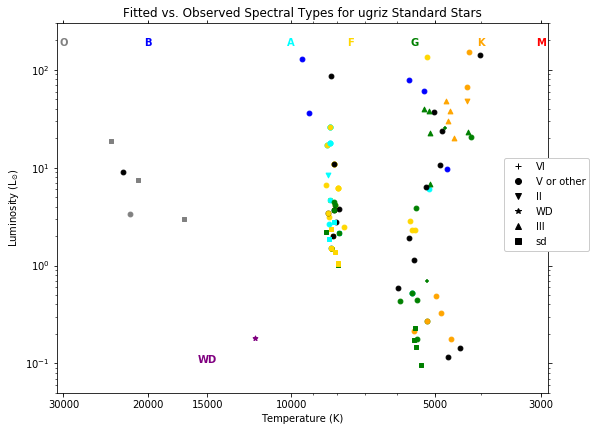

In [397]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8.8,6.8]
import matplotlib.ticker
for x,y,c,m in zip(t['star.temperature'],t['star.Lsun'],colors,classes):
#plt.scatter((t['star.temperature']),(t['star.Lsun']),c=colors,s=10,marker=classes)
    plt.scatter(x,y,c=c,s=23,marker=m)
plt.xlim(2900,31000)
plt.ylim(0.05,300)
plt.xlabel("Temperature (K)")
plt.ylabel("Luminosity (L$_{\odot}$)")
ax = plt.gca()
ax.invert_xaxis()
plt.text(30000,175,"O",horizontalalignment='center',color=getcolor("O"),weight='bold')
plt.text(20000,175,"B",horizontalalignment='center',color=getcolor("B"),weight='bold')
plt.text(10000,175,"A",horizontalalignment='center',color=getcolor("A"),weight='bold')
plt.text(7500,175,"F",horizontalalignment='center',color=getcolor("F"),weight='bold')#,backgroundcolor='gray')
plt.text(5500,175,"G",horizontalalignment='center',color=getcolor("G"),weight='bold')
plt.text(4000,175,"K",horizontalalignment='center',color=getcolor("K"),weight='bold')
plt.text(3000,175,"M",horizontalalignment='center',color=getcolor("M"),weight='bold')
plt.text(15000,0.1,"WD",horizontalalignment='center',color=getcolor("DA"),weight='bold')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([3000,5000,10000,15000,20000,30000])
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(top=True, which="minor",axis="x")
ax.tick_params(right=True, which="minor",axis="y")

ax.get_xaxis().set_major_formatter(ScalarFormatter())
#ax.get_xaxis().set_minor_formatter(ScalarFormatter())
u = list(set(classes))
plt.title('Fitted vs. Observed Spectral Types for ugriz Standard Stars')

patches = [plt.plot([],[],marker=z,ls="",color='black',label=lu[z])[0] for z in u]
plt.legend(handles=patches,loc='best',numpoints=1,ncol=1, bbox_to_anchor=(.9,0.65),framealpha=1)
#print(len(u),len(lu))
plt.savefig("HRdiagram.pdf")


In [1]:
t.show_in_browser(display_length=5)

NameError: name 't' is not defined